In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [5]:
# Charger les données depuis le fichier CSV
data_pays = pd.read_csv("exports_pays.csv", delimiter=',')

In [6]:
# Fonction pour préparer la série temporelle pour un produit donné
def prepare_timeseries(data, produit):
    product_data = data[data['produit'] == produit]
    product_data = product_data.drop(columns=['produit', 'pays', *data.columns[-20:]])
    product_data = product_data.set_index(pd.Index(range(2000, 2000 + len(product_data.columns))))
    return product_data.sum(axis=0)

In [8]:
# Fonction pour entraîner et prévoir avec un modèle ARIMA
def train_and_forecast(product_series, steps=5):
    model = ARIMA(product_series, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

In [9]:
# Fonction pour visualiser les prévisions
def plot_forecast(product, product_series, forecast):
    plt.figure(figsize=(10, 5))
    plt.plot(product_series, label='Historique')
    plt.plot(range(product_series.index[-1] + 1, product_series.index[-1] + 1 + len(forecast)), forecast, label='Prévisions', color='red')
    plt.title(f'Prévisions pour {product}')
    plt.xlabel('Année')
    plt.ylabel('Valeur d\'exportation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Prévoir la demande pour chaque produit
products = ['CITRON', 'MELON', 'TOMATE']
forecast_steps = 5


17:08:55 - cmdstanpy - INFO - Chain [1] start processing
17:08:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


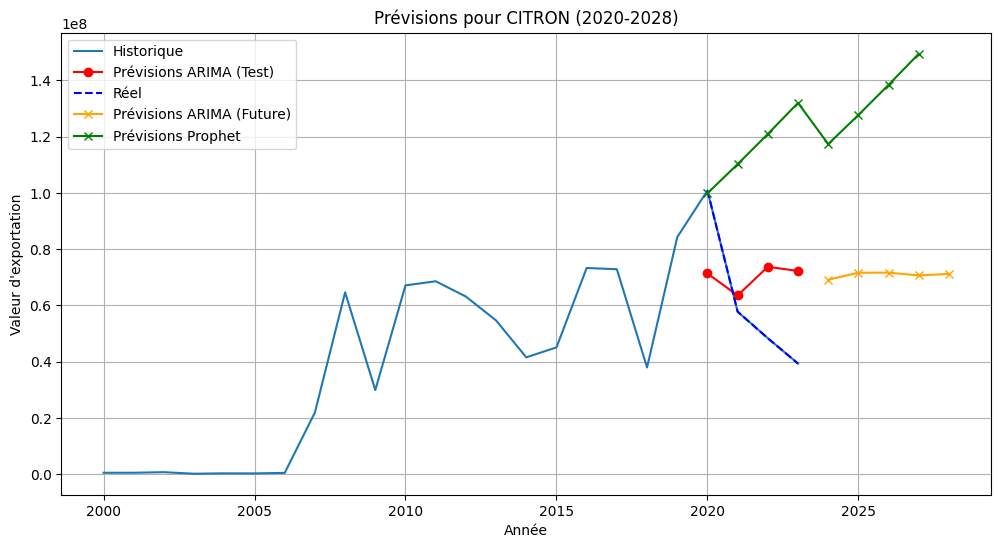

ARIMA MSE pour CITRON: 658237083653815.2
Prophet MSE pour CITRON: 4155214760425653.0


c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
17:08:56 - cmdstanpy - INFO - Chain [1] start processing
17:08:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


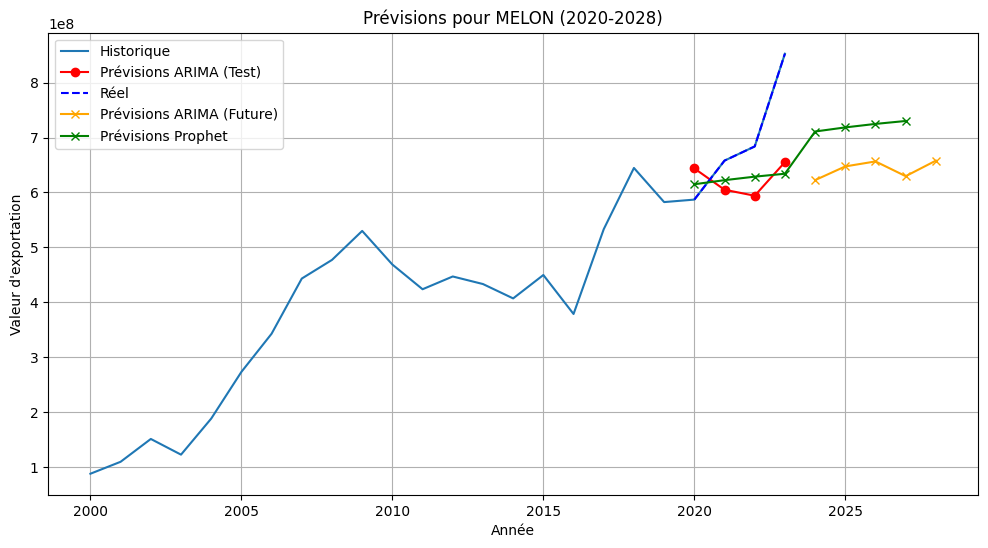

ARIMA MSE pour MELON: 1.3275122826871442e+16
Prophet MSE pour MELON: 1.321871725029678e+16


17:08:57 - cmdstanpy - INFO - Chain [1] start processing
17:08:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\benzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


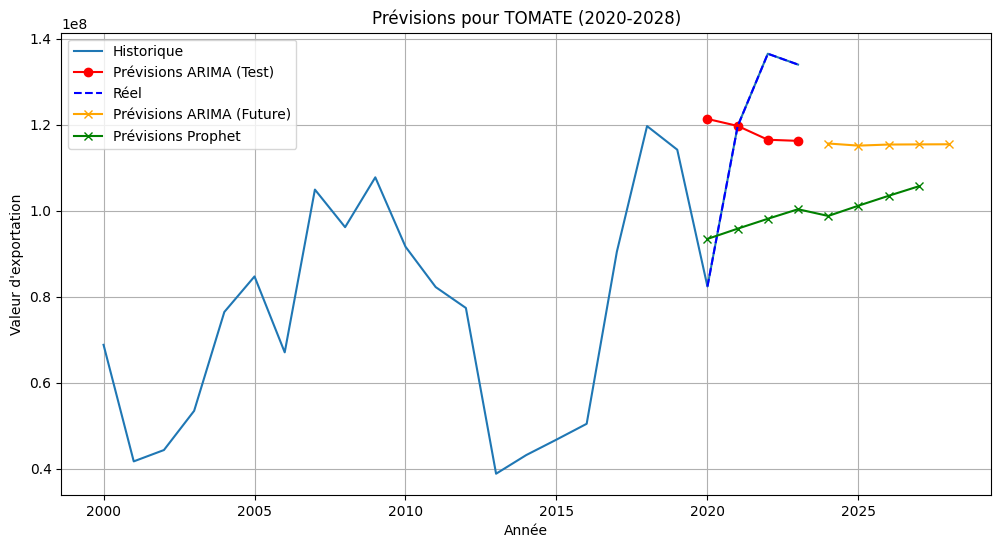

ARIMA MSE pour TOMATE: 558402622353727.8
Prophet MSE pour TOMATE: 823873880119498.2


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# Charger les données depuis le fichier CSV
data_pays = pd.read_csv("exports_pays.csv", delimiter=',')

# Fonction pour préparer la série temporelle pour un produit donné
def prepare_timeseries(data, produit):
    product_data = data[data['produit'] == produit]
    # Sélectionner uniquement les colonnes de valeurs d'exportation par année
    valeur_columns = [col for col in data.columns if col.startswith('valeur_')]
    product_data = product_data[valeur_columns]
    product_data = product_data.sum(axis=0)
    product_data.index = pd.Index(range(2000, 2000 + len(product_data)))
    return product_data

# Fonction pour entraîner et prévoir avec un modèle ARIMA
def train_and_forecast_arima(product_series, train_end_year=2019, steps=5):
    train_size = train_end_year - 2000 + 1
    train, test = product_series[:train_size], product_series[train_size:]
    
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test) + steps)
    return model_fit, forecast[:len(test)], forecast[len(test):], test

# Fonction pour entraîner et prévoir avec Prophet
def train_and_forecast_prophet(product_series, train_end_year=2019, steps=5):
    df = product_series.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    train = df[df['ds'].dt.year <= train_end_year]
    test_years = df[df['ds'].dt.year > train_end_year]['ds'].dt.year
    
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=steps + len(test_years), freq='Y')
    forecast = model.predict(future)
    
    return model, forecast, test_years

# Fonction pour visualiser les prévisions
def plot_forecast(product, product_series, arima_forecast, arima_test, arima_future_forecast, prophet_forecast, train_end_year=2019):
    plt.figure(figsize=(12, 6))
    plt.plot(product_series, label='Historique')
    
    forecast_years = range(train_end_year + 1, train_end_year + 1 + len(arima_forecast))
    plt.plot(forecast_years, arima_forecast, label='Prévisions ARIMA (Test)', color='red', marker='o')
    plt.plot(forecast_years, arima_test, label='Réel', color='blue', linestyle='dashed')
    
    future_forecast_years = range(train_end_year + 1 + len(arima_forecast), train_end_year + 1 + len(arima_forecast) + len(arima_future_forecast))
    plt.plot(future_forecast_years, arima_future_forecast, label='Prévisions ARIMA (Future)', color='orange', marker='x')
    
    # Afficher uniquement les prévisions Prophet pour les années après la fin de l'ensemble d'entraînement
    prophet_future_forecast = prophet_forecast[prophet_forecast['ds'].dt.year > train_end_year]
    plt.plot(prophet_future_forecast['ds'].dt.year, prophet_future_forecast['yhat'], label='Prévisions Prophet', color='green', marker='x')
    
    plt.title(f'Prévisions pour {product} (2020-2028)')
    plt.xlabel('Année')
    plt.ylabel('Valeur d\'exportation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculer le MSE des prévisions
def calculate_mse(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values)

# Prévoir la demande pour chaque produit
products = ['CITRON', 'MELON', 'TOMATE']
forecast_steps = 5  # Nombre d'étapes de prévision pour 2024 à 2028

for product in products:
    product_series = prepare_timeseries(data_pays, product)
    arima_model_fit, arima_forecast, arima_future_forecast, arima_test = train_and_forecast_arima(product_series, train_end_year=2019, steps=forecast_steps)
    prophet_model, prophet_forecast, test_years = train_and_forecast_prophet(product_series, train_end_year=2019, steps=forecast_steps)
    
    plot_forecast(product, product_series, arima_forecast, arima_test, arima_future_forecast, prophet_forecast, train_end_year=2019)
    
    arima_mse = calculate_mse(arima_test, arima_forecast)
    prophet_test_forecast = prophet_forecast[prophet_forecast['ds'].dt.year.isin(test_years)]['yhat']
    prophet_mse = calculate_mse(arima_test.values, prophet_test_forecast.values)
    
    print(f'ARIMA MSE pour {product}: {arima_mse}')
    print(f'Prophet MSE pour {product}: {prophet_mse}')
